Code To Augment Images


In [1]:
import os
import cv2
import albumentations as A

# --- Configuration ---
INPUT_DIR = "masked"
OUTPUT_DIR = "augmented_masked"
# We need ~33 augmentations per image to reach 300. Let's make it 34.
# Total images will be 9 * 34 = 306.
TARGET_COUNT_PER_IMAGE = 34

# --- Define the Augmentation Pipeline ---
# This pipeline applies a series of random transformations to each image.
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.06, scale_limit=0.1, rotate_limit=45, p=0.8),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
    A.MotionBlur(blur_limit=7, p=0.5)
])

# --- Main Script ---
def augment_images():
    """
    Reads images from INPUT_DIR, applies augmentations, and saves them to OUTPUT_DIR.
    """
    # Create output directory if it doesn't exist
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    try:
        image_files = [f for f in os.listdir(INPUT_DIR) if f.endswith(('.png', '.jpg', '.jpeg'))]
        if not image_files:
            print(f"Error: No images found in the '{INPUT_DIR}' directory.")
            return
    except FileNotFoundError:
        print(f"Error: Input directory '{INPUT_DIR}' not found. Please create it.")
        return

    total_generated = 0
    print(f"Found {len(image_files)} source images. Starting augmentation...")

    # Loop through each source image
    for filename in image_files:
        image_path = os.path.join(INPUT_DIR, filename)
        # Read the image using OpenCV
        image = cv2.imread(image_path)
        # Convert from BGR (OpenCV default) to RGB for Albumentations
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        base_filename = os.path.splitext(filename)[0]
        print(f"  -> Augmenting '{filename}'...")

        # Generate the target number of augmented versions
        for i in range(TARGET_COUNT_PER_IMAGE):
            # Apply the augmentation pipeline
            augmented_data = transform(image=image)
            augmented_image = augmented_data['image']

            # Convert back to BGR to save with OpenCV
            augmented_image_bgr = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)

            # Define the new filename and save the image
            output_filename = f"{base_filename}_aug_{i+1}.jpg"
            cv2.imwrite(os.path.join(OUTPUT_DIR, output_filename), augmented_image_bgr)
            total_generated += 1

    print(f"\nDone! ✅ Generated {total_generated} images in the '{OUTPUT_DIR}' folder.")

if __name__ == "__main__":
    augment_images()

c:\Users\sreeh\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\sreeh\AppData\Local\Programs\Python\Python310\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\sreeh\AppData\Local\Temp\ipykernel_9244\3139754826.py:19: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),


Found 7 source images. Starting augmentation...
  -> Augmenting '1.png'...
  -> Augmenting '2.png'...
  -> Augmenting '3.png'...
  -> Augmenting '4.png'...
  -> Augmenting '5.png'...
  -> Augmenting '6.png'...
  -> Augmenting '7.png'...

Done! ✅ Generated 238 images in the 'augmented_masked' folder.


In [7]:
import os

# --- Configuration ---
# The folder with more files (the one we will delete from)
IMAGES_DIR = "augmented_vadas"
# The folder with fewer files (the one we use as a reference)
MASKS_DIR = "augmented_masked" # Corrected to your folder name

def sync_folders():
    """
    Deletes files from the images directory that do not have a
    corresponding file in the masks directory.
    """
    print("Checking for files to synchronize...")
    
    # Get a list of all mask filenames. Using a set is fast for lookups.
    try:
        mask_filenames = set(os.listdir(MASKS_DIR))
        image_filenames = os.listdir(IMAGES_DIR)
    except FileNotFoundError:
        print(f"Error: Make sure both '{IMAGES_DIR}' and '{MASKS_DIR}' folders exist.")
        return

    files_to_delete = []
    # Find which images don't have a matching mask
    for image_file in image_filenames:
        if image_file not in mask_filenames:
            files_to_delete.append(image_file)

    if not files_to_delete:
        print("Folders are already synchronized. No files to delete.")
        return

    print(f"Found {len(files_to_delete)} images without a matching mask. Deleting them...")

    # Delete the extra files
    for filename in files_to_delete:
        os.remove(os.path.join(IMAGES_DIR, filename))

    print("\nDone! ✅")
    print(f"Files in '{IMAGES_DIR}': {len(os.listdir(IMAGES_DIR))}")
    print(f"Files in '{MASKS_DIR}': {len(os.listdir(MASKS_DIR))}")
    print("Both folders are now synchronized.")


if __name__ == "__main__":
    sync_folders()

Checking for files to synchronize...
Folders are already synchronized. No files to delete.


Splitting Dataset

In [6]:
import os
import shutil
import random

# --- Configuration ---
# Source folders containing your full augmented dataset
SOURCE_IMAGES_DIR = "augmented_vadas"
SOURCE_MASKS_DIR = "augmented_masked"

# Destination folders to be created
DEST_TRAIN_A = "trainA"  # 80% of real images
DEST_TEST_A = "testA"    # 20% of real images
DEST_TRAIN_B = "trainB"  # 80% of masks
DEST_TEST_B = "testB"    # 20% of masks

# Split ratio
SPLIT_RATIO = 0.20

# --- Main Script ---
def create_final_dataset():
    """
    Copies files from source augmented folders into a new, split
    train/test structure required by the CycleGAN model.
    """
    # Create all destination directories
    for path in [DEST_TRAIN_A, DEST_TEST_A, DEST_TRAIN_B, DEST_TEST_B]:
        os.makedirs(path, exist_ok=True)

    # Get the master list of filenames from the images folder
    try:
        filenames = os.listdir(SOURCE_IMAGES_DIR)
    except FileNotFoundError:
        print(f"Error: Source directory '{SOURCE_IMAGES_DIR}' not found.")
        return

    # Shuffle the list to ensure a random split
    random.shuffle(filenames)

    # Calculate the split point
    split_index = int(len(filenames) * (1 - SPLIT_RATIO))

    # Divide the list into training and testing sets
    train_files = filenames[:split_index]
    test_files = filenames[split_index:]

    print("Splitting files...")

    # Copy training files
    for filename in train_files:
        # Copy image to trainA
        shutil.copy2(os.path.join(SOURCE_IMAGES_DIR, filename), os.path.join(DEST_TRAIN_A, filename))
        # Copy corresponding mask to trainB
        shutil.copy2(os.path.join(SOURCE_MASKS_DIR, filename), os.path.join(DEST_TRAIN_B, filename))

    # Copy testing files
    for filename in test_files:
        # Copy image to testA
        shutil.copy2(os.path.join(SOURCE_IMAGES_DIR, filename), os.path.join(DEST_TEST_A, filename))
        # Copy corresponding mask to testB
        shutil.copy2(os.path.join(SOURCE_MASKS_DIR, filename), os.path.join(DEST_TEST_B, filename))

    print("\nDone! ✅")
    print(f"Total training images (trainA): {len(os.listdir(DEST_TRAIN_A))}")
    print(f"Total testing images (testA):   {len(os.listdir(DEST_TEST_A))}")
    print(f"Total training masks (trainB):  {len(os.listdir(DEST_TRAIN_B))}")
    print(f"Total testing masks (testB):    {len(os.listdir(DEST_TEST_B))}")

if __name__ == "__main__":
    create_final_dataset()

Splitting files...

Done! ✅
Total training images (trainA): 190
Total testing images (testA):   48
Total training masks (trainB):  190
Total testing masks (testB):    48


In [8]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import os

# --- Configuration - CHANGE THIS VALUE ---
INPUT_IMAGE_PATH = 'vada_pics/1.jpg'
MODEL_PATH = 'models/35_net_G.pth'
OUTPUT_IMAGE_PATH = 'result.png'
# ----------------------------------------

# ----------------------------------------------------------------------------------
# MODEL ARCHITECTURE
# ----------------------------------------------------------------------------------
class ResnetGenerator(nn.Module):
    # --- FIX: Changed default norm_layer from BatchNorm2d to InstanceNorm2d ---
    def __init__(self, input_nc, output_nc, ngf=64, n_blocks=9, n_blocks_use_dropout=False, norm_layer=nn.InstanceNorm2d, padding_type='reflect'):
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        # If InstanceNorm, use bias. If BatchNorm, don't.
        use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=n_blocks_use_dropout, use_bias=use_bias)]

        model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                     kernel_size=3, stride=2,
                                     padding=1, output_padding=1,
                                     bias=use_bias),
                  norm_layer(int(ngf * mult / 2)),
                  nn.ReLU(True)]
        model += [nn.ConvTranspose2d(int(ngf * mult / 2), ngf,
                                     kernel_size=3, stride=2,
                                     padding=1, output_padding=1,
                                     bias=use_bias),
                  norm_layer(ngf),
                  nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        return self.model(input)


class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            p = 1
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim),
                       nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            p = 1
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim)]
        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out
# ----------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------
# MAIN SCRIPT LOGIC
# ----------------------------------------------------------------------------------
def run_inference(input_path, output_path, model_path):
    model = ResnetGenerator(input_nc=3, output_nc=3, ngf=64, n_blocks=9)
    print(f"Loading model from {model_path}...")
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)
    model.eval()
    print("Model loaded successfully.")

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    try:
        input_image = Image.open(input_path).convert('RGB')
    except FileNotFoundError:
        print(f"Error: Input image not found at '{input_path}'")
        return

    input_tensor = transform(input_image).unsqueeze(0)
    with torch.no_grad():
        output_tensor = model(input_tensor)

    output_image_data = (output_tensor.squeeze().permute(1, 2, 0).numpy() + 1) / 2.0 * 255.0
    output_image = Image.fromarray(output_image_data.astype('uint8'))

    output_dir = os.path.dirname(output_path)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    output_image.save(output_path)
    print(f"Successfully converted image and saved result to '{output_path}'")
# ----------------------------------------------------------------------------------


# --- RUN THE SCRIPT ---
run_inference(INPUT_IMAGE_PATH, OUTPUT_IMAGE_PATH, MODEL_PATH)

Loading model from models/35_net_G.pth...
Model loaded successfully.
Successfully converted image and saved result to 'result.png'



--- Vada Analysis Report (Standardized VPI-S) ---
Analyzing: 1.jpg
---------------------------------
Size Score: 0.55 (0-1)
Shape Score (Circularity): 0.76 (0-1)
Hole Score: 0.76 (0-1)
Color Score: 0.39 (0-1)
---------------------------------
✨ Standardized VPI (VPI-S): 65.19 / 100 ✨
Visual report saved to: analyzed_results\report_1.jpg


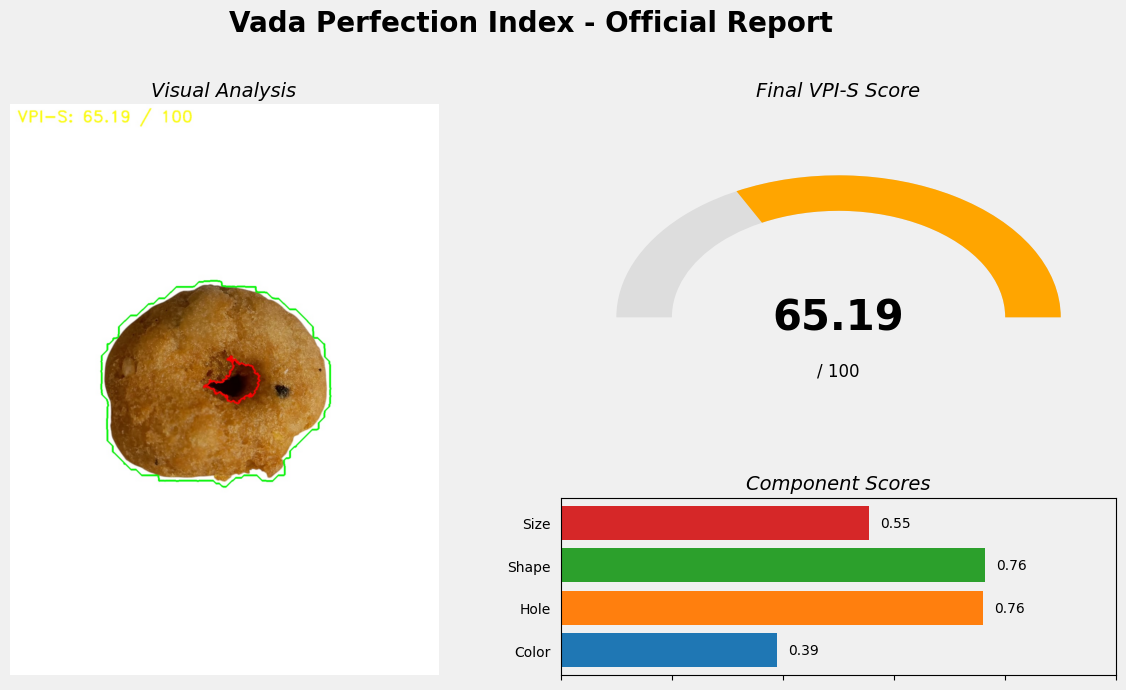

In [10]:
import cv2
import numpy as np
import math
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# This is the Vada analysis engine. It remains unchanged.
def rate_my_vada(image_path, output_dir='analyzed_results'):
    """
    Analyzes a vada and calculates the Standardized VPI (VPI-S) on a 0-100 scale.
    """
    # --- 1. Load Image ---
    if not os.path.exists(image_path):
        print(f"ERROR: File not found at '{image_path}'")
        return None
    color_image = cv2.imread(image_path)
    if color_image is None:
        return None
    
    annotated_image = color_image.copy()
    gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
    img_height, img_width = color_image.shape[:2]

    # --- 2. GrabCut for the OUTER CONTOUR ---
    mask = np.zeros(color_image.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (int(img_width*0.1), int(img_height*0.1), int(img_width*0.8), int(img_height*0.8))
    cv2.grabCut(color_image, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    binary_mask_grabcut = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    contours, _ = cv2.findContours(binary_mask_grabcut, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    vada_contour = max(contours, key=cv2.contourArea)

    # --- 3. Hybrid Method to Find Hole ---
    vada_mask = np.zeros(gray_image.shape, np.uint8)
    cv2.drawContours(vada_mask, [vada_contour], -1, 255, -1)
    vada_only_gray = cv2.bitwise_and(gray_image, gray_image, mask=vada_mask)
    _, hole_thresh = cv2.threshold(vada_only_gray, 50, 255, cv2.THRESH_BINARY)
    hole_mask = cv2.bitwise_not(hole_thresh)
    hole_mask = cv2.bitwise_and(hole_mask, hole_mask, mask=vada_mask)
    hole_contours, _ = cv2.findContours(hole_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    D_hole = 0
    hole_contour = None
    if hole_contours:
        hole_contour = max(hole_contours, key=cv2.contourArea)
        _, radius_hole = cv2.minEnclosingCircle(hole_contour)
        D_hole = 2 * radius_hole
    
    # --- 4. Calculate the Standardized Scores (0-1) ---
    _, radius_vada = cv2.minEnclosingCircle(vada_contour)
    D_avg = 2 * radius_vada
    S_size = D_avg / img_width
    net_area = cv2.countNonZero(vada_mask) - cv2.countNonZero(hole_mask)
    perimeter = cv2.arcLength(vada_contour, True)
    S_shape = (4 * math.pi * net_area) / (perimeter**2) if perimeter > 0 else 0
    S_hole = (1 - (D_hole / D_avg)) if D_avg > 0 else 0
    IDEAL_GOLDEN_BROWN_RATIO = 0.3
    img_hsv = cv2.cvtColor(color_image, cv2.COLOR_BGR2HSV)
    lower_brown = np.array([10, 80, 50])
    upper_brown = np.array([30, 255, 200])
    brown_mask = cv2.inRange(img_hsv, lower_brown, upper_brown)
    brown_pixels = cv2.countNonZero(cv2.bitwise_and(brown_mask, vada_mask))
    rho_gb = brown_pixels / net_area if net_area > 0 else 0
    S_color = 1 - abs(IDEAL_GOLDEN_BROWN_RATIO - rho_gb)

    # --- 5. Calculate Final VPI-S ---
    # Example weights
    w_size, w_shape, w_hole, w_color = 0.01, 0.4, 0.3, 0.29 # Sum = 1.0
    vpi_s = (w_size*S_size + w_shape*S_shape + w_hole*S_hole + w_color*S_color) * 100
    
    # --- 6. Create Annotated Image ---
    cv2.drawContours(annotated_image, [vada_contour], -1, (0, 255, 0), 3)
    if hole_contour is not None:
        cv2.drawContours(annotated_image, [hole_contour], -1, (0, 0, 255), 3)
    report_text = f"VPI-S: {vpi_s:.2f} / 100"
    cv2.putText(annotated_image, report_text, (20, 50), cv2.FONT_HERSHEY_DUPLEX, 1.5, (0, 255, 255), 2)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    base_filename = os.path.basename(image_path)
    save_path = os.path.join(output_dir, f"final_analyzed_{base_filename}")
    cv2.imwrite(save_path, annotated_image)

    return {
        'filename': base_filename, 'VPI_S': vpi_s, 'S_size': S_size,
        'S_shape': S_shape, 'S_hole': S_hole, 'S_color': S_color,
        'annotated_image_path': save_path
    }

# --- NEW: Visual Report Generator ---
def create_visual_report(results, output_dir='analyzed_results'):
    """Creates a dashboard-style visual report of the VPI analysis."""
    
    # Define data
    vpi_score = results['VPI_S']
    scores = {
        'Color': results['S_color'],
        'Hole': results['S_hole'],
        'Shape': results['S_shape'],
        'Size': results['S_size']
    }
    labels = list(scores.keys())
    values = list(scores.values())
    
    # Create figure
    fig = plt.figure(figsize=(12, 7), facecolor='#F0F0F0')
    fig.suptitle('Vada Perfection Index - Official Report', fontsize=20, weight='bold')

    # Create layout grid
    gs = fig.add_gridspec(2, 2, height_ratios=[2, 1])
    
    # --- Subplot 1: Annotated Vada Image ---
    ax_img = fig.add_subplot(gs[:, 0])
    annotated_img = plt.imread(results['annotated_image_path'])
    ax_img.imshow(annotated_img)
    ax_img.axis('off')
    ax_img.set_title('Visual Analysis', fontsize=14, style='italic')

    # --- Subplot 2: VPI Gauge ---
    ax_gauge = fig.add_subplot(gs[0, 1])
    ax_gauge.set_facecolor('#F0F0F0')
    ax_gauge.set_title('Final VPI-S Score', fontsize=14, style='italic')
    
    # Draw gauge background
    gauge_bg = patches.Wedge((0.5, 0.4), 0.4, 0, 180, facecolor='#DDDDDD', width=0.1)
    ax_gauge.add_patch(gauge_bg)

    # Draw gauge fill based on score
    color = 'red' if vpi_score < 40 else ('orange' if vpi_score < 75 else 'green')
    gauge_fill = patches.Wedge((0.5, 0.4), 0.4, 0, vpi_score * 1.8, facecolor=color, width=0.1)
    ax_gauge.add_patch(gauge_fill)
    
    # Add score text
    ax_gauge.text(0.5, 0.4, f'{vpi_score:.2f}', ha='center', va='center', fontsize=30, weight='bold')
    ax_gauge.text(0.5, 0.25, '/ 100', ha='center', va='center', fontsize=12)
    
    ax_gauge.set_xlim(0, 1)
    ax_gauge.set_ylim(0, 1)
    ax_gauge.axis('off')

    # --- Subplot 3: Component Scores Bar Chart ---
    ax_bar = fig.add_subplot(gs[1, 1])
    ax_bar.set_facecolor('#F0F0F0')
    ax_bar.barh(labels, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    ax_bar.set_xlim(0, 1)
    ax_bar.set_title('Component Scores', fontsize=14, style='italic')
    ax_bar.tick_params(left=False, labelbottom=False) # Hide ticks
    # Add value labels to bars
    for index, value in enumerate(values):
        ax_bar.text(value + 0.02, index, f'{value:.2f}', va='center')

    # --- Finalize and Save ---
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    report_path = os.path.join(output_dir, f"report_{results['filename']}")
    fig.savefig(report_path)
    print(f"Visual report saved to: {report_path}")
    plt.show()

# --- EXAMPLE USAGE ---
test_vada_path ="vada_pics/1.jpg"  # Replace with your test image path
results = rate_my_vada(test_vada_path)

if results:
    # Print the text report
    print("\n--- Vada Analysis Report (Standardized VPI-S) ---")
    print(f"Analyzing: {results['filename']}")
    print("---------------------------------")
    print(f"Size Score: {results['S_size']:.2f} (0-1)")
    print(f"Shape Score (Circularity): {results['S_shape']:.2f} (0-1)")
    print(f"Hole Score: {results['S_hole']:.2f} (0-1)")
    print(f"Color Score: {results['S_color']:.2f} (0-1)")
    print("---------------------------------")
    print(f"✨ Standardized VPI (VPI-S): {results['VPI_S']:.2f} / 100 ✨")

    # Create the visual report
    create_visual_report(results)